# Machine learning in practice

--------------------

Prepared by Lukáš Bátrla, Data Scientist at Cisco Systems.

If you find this topic interesting and want to collaborate e.g. on a thesis, feel free to send me a message on [my LinkedIn profile](https://www.linkedin.com/in/lukas-batrla/).

--------------------

## The structure of today's lecture

1. Recap of the data we have.
2. Data cleaning and analysis.
3. Prepare custom dataset and dataloader.
4. Building, training, and evaluation of a model.
5. Model comparison.

In [ ]:
# If you don't have the following packages, install them to your kernel/environment.
%pip install scikit-learn pandas pyarrow seaborn torch tensorboard nids_datasets

## Data

* Source of data; problem that we aim to solve. (motivation)
* Large amount of data; distributed processing.
* Preparation of data sample; data cleaning; various data types; for simplicity filtering only numerical values (using other features is not in scope of this lecture).

### 1. Motivation

There are many areas where we can use ML in the cybersecurity domain. One of them is analyzing the network traffic and finding patterns that lead to malicious behavior. For this, we will use the dataset of **network connections**. Publicly available on https://huggingface.co/datasets/rdpahalavan/UNSW-NB15.

#### Basic dataset info
(taken from the [documentation](https://huggingface.co/datasets/rdpahalavan/UNSW-NB15#dataset-information))
* Network traffic consisting of normal (benign) traffic as well as attack (malicious) traffic.
* The normal traffic and attacks are distinguished by their respective labels: ['normal', 'exploits', 'dos', 'fuzzers', 'generic', 'reconnaissance', 'worms', 'shellcode', 'backdoor', 'analysis'].
* The dataset contains 4 subsets:
    * Network-Flows - Contains flow-level data.
    * **Packet-Fields** - Contains packet header information. (<- We will work with this one.)
    * Packet-Bytes - Contains packet byte information.
    * Payload-Bytes - Contains payload byte information.

#### What do we want to do?
Since the dataset contains samples of attacks, we want to train a model to predict whether the given network communication contains an attack or whether the communication is genuine.

### 2. "Big" data processing

Here we say that we work with "big" data, but it's important to note that even though the dataset that we work with is large, in the network domain we would consider this to be quite small. However, for the showcase of distributed computing it is more than enough since we can't really process it on a single laptop, not to speak of processing it with a single CPU.

**Some statistics**
* The whole dataset:
    * Up to 230 million network connections.
        * That is a large dataset, but not as large as the real network traffic that companies need to deal with. (The Cisco Prague office used to process ~60B flows daily, ~1B packets.)
    * Around 300 GB of parquet files.
* Packet-Fields:
    * 18 parquet files, each with ~10 million samples (size of about 15 GB).
* Packet-Fields file #13:
    * ~10 million samples.
    * Distribution of attack_labels:

|  attack_label|  count|
|:-------------|------:|
|       generic|  29415|
|     shellcode|   1396|
|        normal|9618777|
|         worms|   1688|
|reconnaissance|  14069|
|       fuzzers|  44183|
|           dos|  57220|
|      backdoor|   1809|
|      exploits| 226910|
|      analysis|    436|

Normally, we'd use the whole Packet-Fields file but since we want to train our model locally, we'll take only 1/10th of the data so that it fits into memory.

#### Data download

[Note] The scope of this lecture is NOT distributed computing. Below is a code that repartitions the input data into the attack label categories. In case the following code doesn't work on your device and you want to do the processing yourself, check this [notebook from last year](https://gitlab.fjfi.cvut.cz/ksi/ppy2-2023/-/blob/main/Zpracov%C3%A1n%C3%AD%20a%20anal%C3%BDza%20dat/Class_Initial_Notebook.ipynb) where my colleague, Cenek Skarda, walks through the pyspark setup.

The following cells cover:
* Download data + split into batches
    * As an example, we'll download one of the Packet-Fields files. Even though it's just one file, it is quite large (~14 GB), so we'll divide it into smaller batches (per 100k records).

In [ ]:
# Download file #13 from the Packet-Fields subset.
from nids_datasets import Dataset, DatasetInfo

dataset = 'UNSW-NB15' # or 'CIC-IDS2017'
subset = ['Packet-Fields'] # or 'all' for all subsets
files = [13] # or 'all' for all files

data = Dataset(dataset=dataset, subset=subset, files=files)
data.download()

In [ ]:
# Split the data into smaller batches.
import pyarrow.parquet as pq

parquet_file = pq.ParquetFile('UNSW-NB15/Packet-Fields/Packet_Fields_File_13.parquet')
output_dir = './data/rawdata'

k = 0
for i in parquet_file.iter_batches(batch_size=100000):
    k = k + 1
    print(f"RecordBatch {k}")
    i.to_pandas().to_parquet(f"{output_dir}/Packet_Fields_File_13_{str(k)}.parquet")

* Load the batched parquet files and create a dataset with respect to the attack labels. In a real-world application, we'd use a smarter way to deal with the class imbalance, but here, for the sake of simplicity, we'll take all "malicious" data and a sample of the benign class. That will decrease the amount of benign data in the dataset => more balanced dataset.

In [ ]:
# Run only if you have pyspark installed and want to process the data yourself.
import pyspark
import time
from pyspark.sql import SparkSession

number_cores = 8
memory_gb = 10

# Initialize spark session.
spark = SparkSession.builder \
    .master('local[{}]'.format(number_cores)) \
    .config('spark.driver.memory', '{}g'.format(memory_gb)) \
    .appName('KSI class') \
    .getOrCreate()

# Path to the input data.
data_path = './data/rawdata/Packet_Fields_File_13_*'
# Output directory for partitioned data.
output_path = './data/processeddata/partitionedbylabel/'
benign_sample_path = './data/processeddata/benignsample/'

# Read the data into pyspark's DataFrame.
df = spark.read.option('header', True).parquet(data_path)
# Save the data partitioned by the attack_label into the output path.
df.write.partitionBy('attack_label').parquet(output_path)

# Save sample of the 'normal' class as a way to decrease the class imbalance. This will result in ~700k rows which is much closer to the rest of the attack labels.
df.where('attack_label == "normal"').dropDuplicates().sample(0.08).write.partitionBy('attack_label').parquet(benign_sample_path)

# Stop spark session.
spark.stop()

## Basic data preparation

1. Look at the data.
2. Data cleaning.

### 1. Look at the data

#### Large file that doesn't fit into memory

In [1]:
# In case of larger data, we might use the pyarrow library to access only some smaller batch of the data.
from pyarrow.parquet import ParquetFile

pf = ParquetFile('./data/rawdata/Packet_Fields_File_13_76.parquet')
first_rows = next(pf.iter_batches(batch_size = 5))
first_rows.to_pandas() # Conversion to pandas is only for better displaying options.

,packet_id,flow_id,source_ip,source_port,destination_ip,destination_port,protocol,packet_hex,payload_hex,cooked linux pkttype,...,Link Local Multicast Node Resolution - Response type,PPTP Incoming Call Reply call_id,Kerberos rtime,802.3 src,Kerberos etype,PPTP Echo Request type,Link Local Multicast Node Resolution - Response ar,Link Local Multicast Node Resolution - Response rdlen,802.15.4 - FCS fcs,ESP seq
0,127339564,1446486,149.171.126.5,2637,59.166.0.4,4790,tcp,000000010006001b17059e1c0000080045000038ce2240...,<NA>,unicast,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,127339565,1446489,149.171.126.8,3930,59.166.0.4,49156,tcp,000400010006005056a577630000080045000034038140...,<NA>,sent-by-us,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,127339566,1446489,149.171.126.8,3930,59.166.0.4,49156,tcp,000000010006001b17059e1c0000080045000034038140...,<NA>,unicast,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,127339567,1446489,149.171.126.8,3930,59.166.0.4,49156,tcp,000400010006005056a577630000080045000034038640...,<NA>,sent-by-us,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,127339568,1446486,149.171.126.5,2637,59.166.0.4,4790,tcp,000000010006001b17059e1c0000080045000075ce2c40...,e33c0000004c4754c54fe85c8481c575c3d3c168f738fa...,unicast,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


#### Smaller file that fits into memory

In [2]:
import pandas as pd

df = pd.read_parquet('./data/rawdata/Packet_Fields_File_13_76.parquet')
df

,packet_id,flow_id,source_ip,source_port,destination_ip,destination_port,protocol,packet_hex,payload_hex,cooked linux pkttype,...,Link Local Multicast Node Resolution - Response type,PPTP Incoming Call Reply call_id,Kerberos rtime,802.3 src,Kerberos etype,PPTP Echo Request type,Link Local Multicast Node Resolution - Response ar,Link Local Multicast Node Resolution - Response rdlen,802.15.4 - FCS fcs,ESP seq
0,127339564,1446486,149.171.126.5,2637,59.166.0.4,4790,tcp,000000010006001b17059e1c0000080045000038ce2240...,<NA>,unicast,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,127339565,1446489,149.171.126.8,3930,59.166.0.4,49156,tcp,000400010006005056a577630000080045000034038140...,<NA>,sent-by-us,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,127339566,1446489,149.171.126.8,3930,59.166.0.4,49156,tcp,000000010006001b17059e1c0000080045000034038140...,<NA>,unicast,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,127339567,1446489,149.171.126.8,3930,59.166.0.4,49156,tcp,000400010006005056a577630000080045000034038640...,<NA>,sent-by-us,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,127339568,1446486,149.171.126.5,2637,59.166.0.4,4790,tcp,000000010006001b17059e1c0000080045000075ce2c40...,e33c0000004c4754c54fe85c8481c575c3d3c168f738fa...,unicast,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,127439580,1447742,149.171.126.8,6881,59.166.0.9,20485,tcp,000400010006005056a5776300000800450005dcd3e240...,95f01ed51bf71aea946ead4cf88a1db164f023d7846367...,sent-by-us,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
99996,127439581,1447687,149.171.126.4,22,59.166.0.7,42476,tcp,000400010006005056a5776300000800450004e897cc40...,0d8b47c66818bd137be34d9cd73d754092af3585cb43bd...,sent-by-us,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
99997,127439582,1447687,149.171.126.4,22,59.166.0.7,42476,tcp,000000010006001b17059e1c00000800450004e897cc40...,0d8b47c66818bd137be34d9cd73d754092af3585cb43bd...,unicast,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
99998,127439583,1447742,149.171.126.8,6881,59.166.0.9,20485,tcp,000400010006005056a5776300000800450005dcd39240...,2c3ad427ff58005906533fbb14b6fe492a608736400953...,sent-by-us,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


### 2. Data cleaning

* Filter numerical columns.
* Encode label categories.
* Further data cleaning:
    * Dealing with NaNs (\<NA> values).
    * Remove columns that don't carry useful information, e.g. all values are the same or there are only NaN values for all malicious samples.
    * Remove correlated columns.

#### Filter only numerical columns

[Note] The below filter is not what would be usually sufficient, we do this filtering just for its simplicity. The proper handling of non-numerical columns is part of the assignment below.

In [3]:
numerics = ['int', 'float']
feature_columns = list(df.select_dtypes(include=numerics).columns)  # Get only Integer columns
print(f'Number of numerical columns: {len(feature_columns)}')

Number of numerical columns: 239


**Assignment**
* To have a richer set of information, we could also utilize other (non-numerical) columns. Convert all categorical columns into One-hot encoded vectors. This requires data processing that was mentioned in one of the the previous classes. To remind yourself how to do it, see either [Zpracovani a analyza dat](https://gitlab.fjfi.cvut.cz/ksi/ppy2-2023/-/blob/main/Zpracov%C3%A1n%C3%AD%20a%20anal%C3%BDza%20dat/Class_Notebook.ipynb) (section "Dataset Preparation") or [Uvod do ML](https://gitlab.fjfi.cvut.cz/ksi/ppy2-2023/-/blob/main/%C3%9Avod%20do%20ML/Python-Uvod_do_ML.ipynb) (section "Čištění a úprava dat").

In [4]:
# Placeholder for the assignment

#### Encode label categories
The labels are currently categorical so we transform them to numerical values.

In [5]:
from sklearn.preprocessing import LabelEncoder

# Define what column represents our labels.
label_column = 'attack_label'

# Fit LabelEncoder.
le = LabelEncoder()
le.fit(df[label_column])

# We can check what classes were encoded.
print(le.classes_)
# To convert the string class into a number, use the .transform() method.
print(f'Numerical representation of classes ["normal","dos"] is a list/array {le.transform(["normal","dos"])}.')

['backdoor' 'dos' 'exploits' 'fuzzers' 'generic' 'normal' 'reconnaissance']
Numerical representation of classes ["normal","dos"] is a list/array [5 1].


In [6]:
# Apply the numerical encoding on the whole label column.
df[label_column] = le.transform(df[label_column])

#### Further data cleaning

In [7]:
numerical_w_label_df = df[[*feature_columns, label_column]]
numerical_w_label_df.describe()

,packet_id,flow_id,source_port,destination_port,cooked linux lladdrlen,IP version,IP ihl,IP len,IP id,IP frag,...,Link Local Multicast Node Resolution - Response arcount,SCTPChunkAuthentication len,PPTP Echo Request len,Link Local Multicast Node Resolution - Response ttl,IPv6 Extension Header - Hop-by-Hop Options Header len,Zigbee Encapsulation Protocol (V2) type,PPTP Incoming Call Reply call_id,Link Local Multicast Node Resolution - Response rdlen,ESP seq,attack_label
count,100000.0,100000.0,100000.0,100000.0,100000.0,99996.0,99996.0,99996.0,99996.0,99996.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100000.000000
mean,127389576.94529,1445235.1961,20654.98876,24637.5748,6.0,4.0,5.0,563.686777,39008.936517,0.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,4.828840
std,28872.459994,48218.817129,20730.181554,21102.964965,0.0,0.0,0.0,660.057026,15941.243472,0.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.736498
min,127339564.0,117.0,0.0,0.0,6.0,4.0,5.0,40.0,512.0,0.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.000000
25%,127364575.75,1446884.0,1057.0,5190.0,6.0,4.0,5.0,52.0,31355.0,0.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,5.000000
50%,127389577.5,1447190.0,11739.0,20659.0,6.0,4.0,5.0,74.0,37704.0,0.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,5.000000
75%,127414581.25,1447520.0,39535.0,42476.0,6.0,4.0,5.0,1500.0,51371.0,0.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,5.000000
max,127439584.0,1447970.0,65534.0,65534.0,6.0,4.0,5.0,1500.0,65535.0,0.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,6.000000


From the above table, we see there are some columns with only \<NA> values. These will be the first ones to remove but before doing so, we should think about our task and especially what we don't want our future model to decide on.
The model should not decide based on whether a feature is missing or not. Therefore, all features that contain only \<NA> values for all of our malicious samples (i.e. where the _attack\_label_ != 'normal') should be removed as well.

Now it's time to **do the filtering**.
1. Remove columns with only NaN values. This also applies for columns that contain NaN values only on the malicious samples.

In [8]:
def drop_columns_without_values(df):
    # Remove all columns with only NaN values.
    return df.dropna(axis=1, how='all')

def drop_columns_without_values_on_malicious_samples(df):
    # Filter malicious examples and then remove columns with only NaN values.
    columns_to_keep = df[df[label_column] != le.transform(['normal'])[0]].dropna(axis=1, how='all').columns
    return df[columns_to_keep]

def drop_columns_with_single_value(df):
    # Filter columns that only contain a single value.
    descriptions = df.describe().T
    columns_to_drop = descriptions[(descriptions['min'] == descriptions['max']) & (descriptions['std'] == 0)].index
    return df.drop(columns=columns_to_drop)

clean_df = drop_columns_with_single_value(drop_columns_without_values_on_malicious_samples(numerical_w_label_df))
clean_df.describe().T

,count,mean,std,min,25%,50%,75%,max
packet_id,100000.0,127389576.94529,28872.459994,127339564.0,127364575.75,127389577.5,127414581.25,127439584.0
flow_id,100000.0,1445235.1961,48218.817129,117.0,1446884.0,1447190.0,1447520.0,1447970.0
source_port,100000.0,20654.98876,20730.181554,0.0,1057.0,11739.0,39535.0,65534.0
destination_port,100000.0,24637.5748,21102.964965,0.0,5190.0,20659.0,42476.0,65534.0
IP len,99996.0,563.686777,660.057026,40.0,52.0,74.0,1500.0,1500.0
IP id,99996.0,39008.936517,15941.243472,512.0,31355.0,37704.0,51371.0,65535.0
IP ttl,99996.0,43.677637,52.044956,1.0,29.0,30.0,32.0,255.0
TCP seq,98208.0,2195986927.571837,1264302123.94483,4870941.0,1122422931.0,2101555009.0,3255293315.0,4294585995.0
TCP ack,98208.0,2202007458.617363,1274254999.663323,0.0,1172802721.75,2097528116.0,3255293315.0,4294585996.0
TCP dataofs,98208.0,7.831511,0.767524,5.0,8.0,8.0,8.0,9.0


2. From the remaining columns, we can select the ones that are identifiers and remove them as well.

In [9]:
irrelevant_columns = [
    'packet_id',  # identifier
    'flow_id',  # identifier
    'IP id',  # identifier
    'DNS id',  # identifier
    ]

clean_df = clean_df.drop(columns=irrelevant_columns)

3. Remove highly correlated columns.

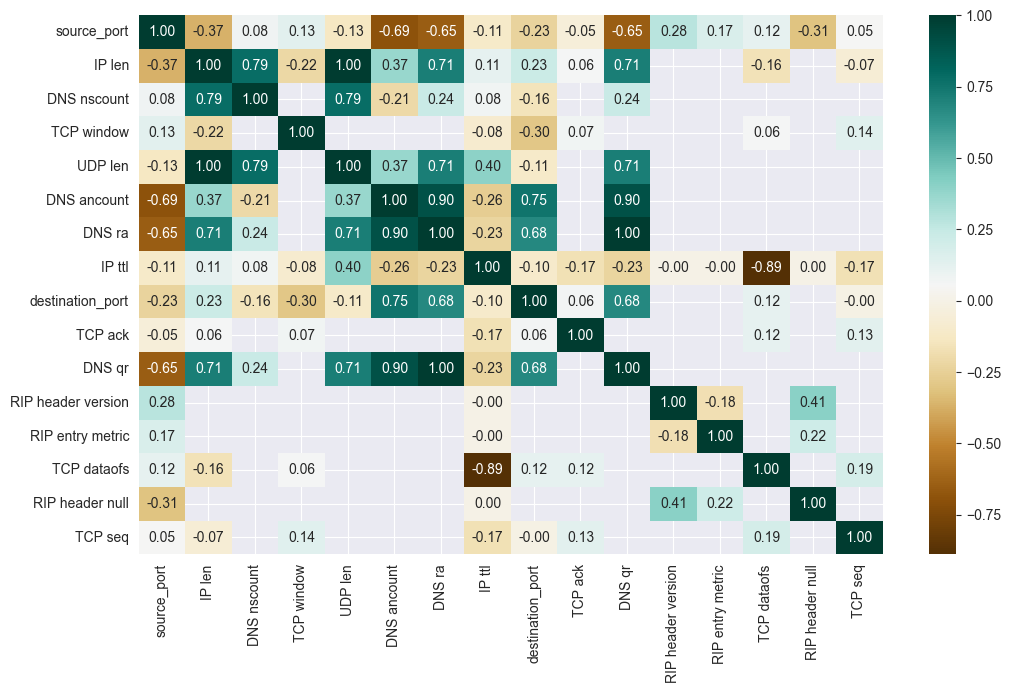

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = set(clean_df.columns)
cols.remove(label_column)
cols = list(cols)
plt.figure(figsize=(12,7))
sns.heatmap(clean_df[cols].corr(), cmap='BrBG', annot=True, fmt='.2f')
plt.show()

Seeing the above correlation matrix, we might jump to conclusion that there are several correlated columns. **However, is it true?** Let's find out..

Before blindly removing the correlated columns, let's first check if they have the same number of non-empty values. If they do, we can remove any of them. If they don't, we should keep the one that has more non-empty samples.

Below are two examples of columns that are highly correlated.

In [11]:
col_1 = 'DNS ra'
col_2 = 'DNS qr'
print(f'# non-empty "{col_1}":', clean_df[col_1].dropna().shape[0])
print(f'# non-empty "{col_2}":', clean_df[col_2].dropna().shape[0])
print(f'# (null "{col_1}" & not-null "{col_2}"):', clean_df[(clean_df[col_1].isna() & (clean_df[col_2].notna()))][[col_1,col_2]].shape[0])
print(f'# (not-null "{col_1}" & null "{col_2}"):', clean_df[(clean_df[col_2].isna() & (clean_df[col_1].notna()))][[col_1,col_2]].shape[0])

# non-empty "DNS ra": 844
# non-empty "DNS qr": 844
# (null "DNS ra" & not-null "DNS qr"): 0
# (not-null "DNS ra" & null "DNS qr"): 0


In [12]:
col_1 = 'UDP len'
col_2 = 'IP len'
print(f'# non-empty "{col_1}":', clean_df[col_1].dropna().shape[0])
print(f'# non-empty "{col_2}":', clean_df[col_2].dropna().shape[0])
print(f'# (null "{col_1}" & not-null "{col_2}"):', clean_df[(clean_df[col_1].isna() & (clean_df[col_2].notna()))][[col_1,col_2]].shape[0])
print(f'# (not-null "{col_1}" & null "{col_2}"):', clean_df[(clean_df[col_2].isna() & (clean_df[col_1].notna()))][[col_1,col_2]].shape[0])

# non-empty "UDP len": 1766
# non-empty "IP len": 99996
# (null "UDP len" & not-null "IP len"): 98230
# (not-null "UDP len" & null "IP len"): 0


From the above examples, we see that:
* `DNS ra` and `DNS qr` have the same number of filled values. And with correlation coef. == 1 we can choose any of them to drop.
* `UDP len` and `IP len` have correlation coef. == 1 but are correlated only on the non-empty samples. When we take into account the fact that they have different sizes of their feature vectors, we might conclude that we keep the one with larger number of non-empty samples. However, this way we'd lose information about the presence of UDP protocol in the packet. Therefore, we should either keep both columns or create a new feature `is UDP` and then drop the `UDP len`.

In [13]:
# Removing "DNS ra" from cols and the dataframe.
cols.remove('DNS ra') 
clean_df = clean_df.drop(columns=['DNS ra'])

The problem with the above correlation matrix is that the correlation was done for paired variables (columns) but removing `<NA>` values. The number of non-empty rows for `IP len` and `UDP len`, one has almost 10k samples, the other less than 2k.

A quick fix would be to:
* Set `min_periods` parameter to define the minimal number of pairs present in the data to have a valid result.
* Fill the `<NA>` values with something, e.g. 0 (zero) which for most of the columns makes sense and doesn't bring any new information to the data.

**Assignment**
* Plot the correlation matrix using the following line: `sns.heatmap(clean_df[cols].fillna(0).corr(), cmap='BrBG', annot=True, fmt='.2f')`. What columns would you remove now as opposed to the *WRONG* correlation matrix above?
* Another interesting information for our later ML task is the relation of the features to the label. Analyze the correlation between the feature columns and the label column.

[Note] When interpreting the correlation matrix, keep in mind that we didn't check whether all our "numerical" columns are continuous. There might be some that represent categories. For such columns, we should use different correlation coefficient than the default Pearson's correlation coefficient.

[Note 2] For the correlation with the label column, keep in mind that we have imbalanced data. It might be worth checking with what label/s the highly correlated column (if there is such) correlates with.

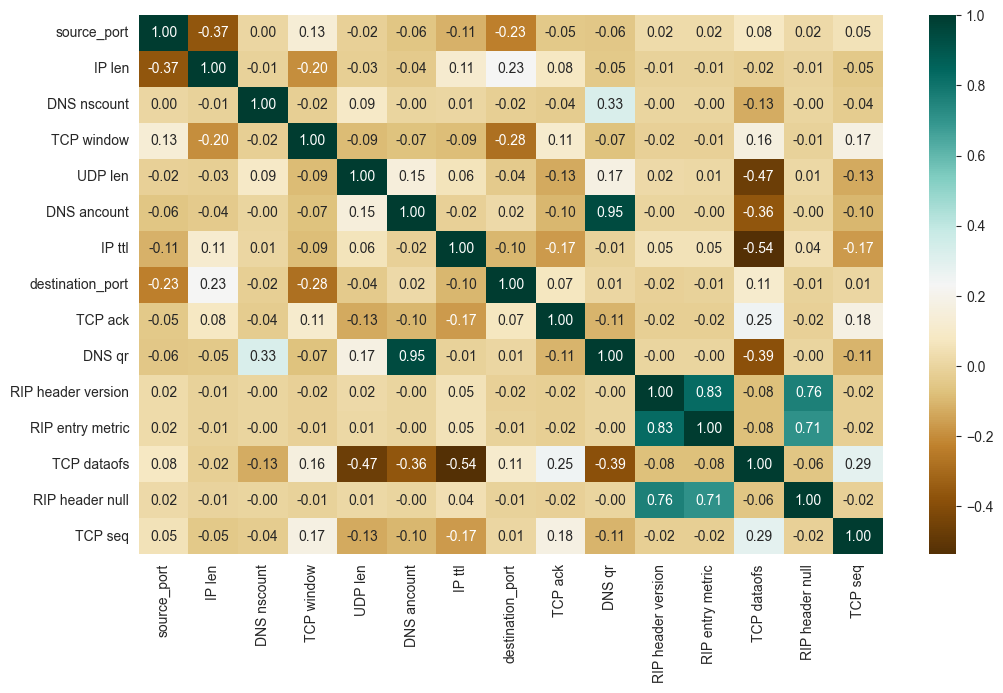

In [14]:
## Placeholder for the first assignment
plt.figure(figsize=(12,7))
sns.heatmap(clean_df[cols].fillna(0).corr(), cmap='BrBG', annot=True, fmt='.2f')
plt.show()

In [15]:
## Placeholder for the second assignment
## The below code snippet helps you start. You should replace the calculation of correlation with a more suitable metric.

# plt.figure(figsize = (5,6))
# sns.heatmap(clean_df.fillna(0).corr()[[label_column]].sort_values(by=label_column, ascending=False), annot=True, cmap='BrBG', yticklabels=1)
# plt.show()

## Creating custom Dataset and DataLoader

Since we have prepared the data ourselves, we'll need a custom dataset, compared to the tasks that you've seen in previous lectures. When creating a custom dataset, there are a few things that one needs to think of:
* Can we load all the data into memory or do we need to load them in batches?
* Are the data already processed or do we need to do some preprocessing? (E.g. normalization)

In the cells bellow, we:
* Create our own custom (pytorch) dataset. The dataset is not much complicated, it contains an `__init__` method where we devide the incomming pandas DataFrame into features (`self.X`) and labels (`self.y`). Possibly we apply label binarization to reduce our 7 original labels into 2 - benign and malicious (= attack) label. The `__get_item__` method returns a single (feature, label) pair. This is especially useful for the DataLoader that we use later, because it allows the DataLoader to construct batches from our CustomDataset. The last compulsary method is `__len__` that returns the size of the dataset.
Other methods are used only for our own convenience - `normalize` normalizes the feature data into [0, 1] interval; `label_counts` returns the (label, count) dictionary that helps us see the distribution of labels in the train, validation, and test datasets.
* We then initialize the datasets and dataloaders, and check that the shapes and distributions align with our dataset design.

In [16]:
# Here we initialize our own pytorch Dataset.

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing


class CustomDataset(Dataset):
    # Initialize the dataset (divided into features and labels) and apply preprocessing (if any).
    def __init__(self, df, columns, label_column, benign_value, label_binarization=False):
        self.X = self.normalize(df[columns])
        if label_binarization:
            self.y = torch.tensor((df[label_column] != benign_value).values.astype('int'))
        else:
            self.y = torch.tensor(df[label_column].values.astype('int'))

    # Get size of the dataset.
    def __len__(self):
        return self.y.shape[0]

    # For each label get it's count in the dataset.
    def label_counts(self):
        labels, counts = self.y.unique(return_counts=True)
        return dict(zip(labels.numpy(), counts.numpy()))

    # Get list of all unique labels.
    def unique_labels(self):
        return list(self.y.unique().numpy())

    # Normalization of features to values from [0, 1] interval.
    def normalize(self, df):
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(df.values)
        return torch.tensor(x_scaled)

    # Get one record (=(feature, label) pair) from the dataset for given index.
    def __getitem__(self, idx):
        return self.X[idx].float(), self.y[idx].long()

In [17]:
# This cell is used to split the data into train, validation, and test sets.
from sklearn.model_selection import train_test_split

data = clean_df.fillna(0).copy()

# Split data into train, validation, test. Note that we use stratify to remain the label proportions in the training and validation data.
train_df, test_df = train_test_split(data, test_size=0.33, random_state=42, stratify=data.attack_label)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)
print(f'Shape of training: {train_df.shape}, validation: {val_df.shape}, test: {test_df.shape}')

Shape of training: (67000, 16), validation: (16500, 16), test: (16500, 16)


In [18]:
# Set batch size and whether we want to solve binary task or multiclass.
batch_size = 64
label_binarization = True

# Get encoded value for the benign (='normal') class.
benign_label = le.transform(['normal'])[0]

# Initialize the datasets and dataloaders for each of the train, validation, and test data.
train_set = CustomDataset(train_df, cols, label_column, benign_label, label_binarization)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
valid_set = CustomDataset(test_df, cols, label_column, benign_label, label_binarization)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_set = CustomDataset(val_df, cols, label_column, benign_label, label_binarization)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False)

# Check what is the label distribution.
print(f'Label distribution in\n training:\t{train_set.label_counts()},\n validation:\t{valid_set.label_counts()},\n test set:\t{test_set.label_counts()}')

Label distribution in
 training:	{0: 62744, 1: 4256},
 validation:	{0: 15477, 1: 1023},
 test set:	{0: 15427, 1: 1073}


In [19]:
# Check the shape of features and labels.
features, labels = next(iter(train_loader))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")

Feature batch shape: torch.Size([64, 15])
Labels batch shape: torch.Size([64])


The shapes and distributions seems aligned with what we intended, so we can move to the model itself.

## Build, train, and evaluate the model

We have the datasets and dataloaders so we can move to building the model. This section covers the following:

0. Auxiliary functions.
1. Model definition.
2. Training and validation.
3. Evaluation on test set.

In [20]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

### 0. Auxiliary functions

In [21]:
# Used for better representation of the model's performance.
def plot_confusion_matrix(cm):
    fig = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    fig.set_title('Confusion matrix')
    fig.set_xlabel('Predicted Class')
    fig.set_ylabel('Actual Class')
    return fig

In [22]:
# This will be later used when dealing with class imbalance.
def get_weights(label_array):
    unique, counts = np.unique(label_array, return_counts=True)
    weights_train = torch.tensor(sum(counts) / counts)
    return weights_train.float()

### 1. Model definition

As you've seen in the previous lectures, the model setup is quite straight forward. We define the input and output dimensions of the model, set the hidden layers, activation functions, dropouts, etc. Set up the loss function and optimizer and we're done.

[Note] A good practice is to check if the forward pass works as expected. Together with checking the output dimensions at various stages in the model, it will spare you countless hours debugging what went wrong and why the model crashes or doesn't learn.

In [23]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first forward pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x

class Model(nn.Module):

    def __init__(self, num_features, num_classes):
        super(Model, self).__init__()
        
        self.net = nn.Sequential(
            PrintSize(),
            nn.Linear(num_features, num_classes)
            # nn.ReLU(),
            # nn.Linear(20, num_classes)
        )
        
    def forward(self, x):
        return self.net(x)

# Get sizes of input and output vectors. We'll use them to set proper dimensions for the model.
num_features = train_set.X.shape[1]
num_classes = train_set.y.unique().shape[0]

# Initialize the model.
model = Model(num_features, num_classes)
print(model)

# Initialize the loss function and optimizer. Possibly also weights to deal with class imbalance.
weights = get_weights(train_set.y.numpy())
loss_fn = nn.CrossEntropyLoss(weight=weights)  # Setting the weights ensures the loss will be computed with respect to the imbalance in the dataset.
# loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Model(
  (net): Sequential(
    (0): PrintSize()
    (1): Linear(in_features=15, out_features=2, bias=True)
  )
)


In [24]:
# Test the forward pass with dummy data.
out = model(torch.randn(2, 15))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().numpy()}")

Size: torch.Size([2, 15])
Output shape: torch.Size([2, 2])
Output logits:
[[-0.563131    0.48423895]
 [ 1.039714    0.63647497]]
Output probabilities:
[[0.25973046 0.74026954]
 [0.5994656  0.4005344 ]]


### 2. Training and validation

Set the number of epochs for training and how often you want to see the validation score. Otherwise, the following block of code is quite standard when training a model in pytorch. For better readability and reusing the code, we could split the code into training and validation functions.

For each 1,000th learning step, we plot the training and validation accuracies to check how the learning progresses.

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Set parameters (number of epochs for training, and step for printing the evaluation on the validation data).
num_epochs = 10
validation_every_steps = 1000

train_accuracies = []
valid_accuracies = []

# Training begins...
step = 0
model.train()
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        
        # Forward pass.
        output = model(inputs)
        # Compute loss.
        loss = loss_fn(output, targets)
        # Clean up gradients from the model.
        optimizer.zero_grad()
        # Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()
        # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()
        
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy_score(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in valid_loader:
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy_score(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(valid_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             validation accuracy: {valid_accuracies[-1]}")

print("Finished training.")

Step 1000    training accuracy: 0.96334375
             validation accuracy: 0.9693939393939394
Step 2000    training accuracy: 0.9694870283018868
             validation accuracy: 0.9764242424242424
Step 3000    training accuracy: 0.9780251927312775
             validation accuracy: 0.9788484848484849
Step 4000    training accuracy: 0.9796802494199536
             validation accuracy: 0.9797575757575757
Step 5000    training accuracy: 0.9804878982843137
             validation accuracy: 0.9814545454545455
Step 6000    training accuracy: 0.9806818181818182
             validation accuracy: 0.9822424242424243
Step 7000    training accuracy: 0.9821521063535912
             validation accuracy: 0.9826060606060606
Step 8000    training accuracy: 0.98234697640118
             validation accuracy: 0.9830909090909091
Step 9000    training accuracy: 0.982842167721519
             validation accuracy: 0.9834545454545455
Step 10000   training accuracy: 0.9821352389078498
             validation 

#### Plot the training results

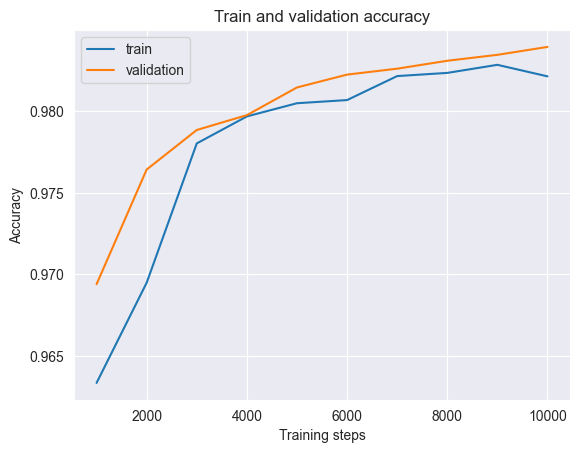

Latest validation accuracy: 0.984


In [26]:
# Plot training and validation accuracies.
steps = (np.arange(len(train_accuracies), dtype=int) + 1) * validation_every_steps

plt.figure()
plt.plot(steps, train_accuracies, label='train')
plt.plot(steps, valid_accuracies, label='validation')
plt.xlabel('Training steps')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Train and validation accuracy")
plt.show()

print(f"Latest validation accuracy: {valid_accuracies[-1]:.3f}")

### 3. Evaluation on test set

Test accuracy: 0.984

Precision:  0.8070175438596491
Recall :  0.9860205032618826
F1 :  0.8875838926174496



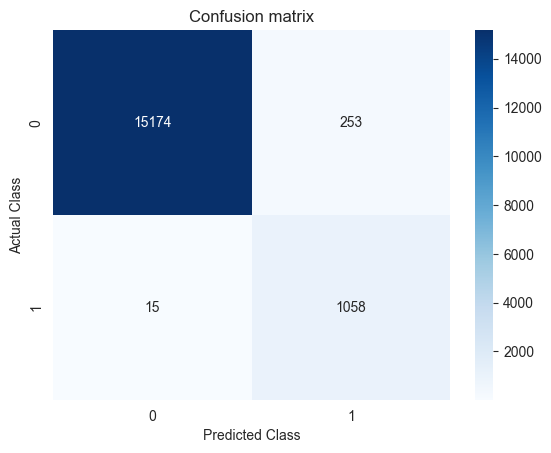

In [27]:
# Evaluate the model on test set. (With confusion matrix.)
CM=0
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Update the confusion matrix.
        CM += confusion_matrix(targets.cpu(), predictions.cpu(), labels=test_set.unique_labels())

        # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy_score(targets, predictions) * len(inputs))

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    print(f"Test accuracy: {test_accuracy:.3f}")

    # For binary classification, print the precision, recall, and F1 score.
    if len(test_set.unique_labels()) == 2:
        tn=CM[0][0]
        tp=CM[1][1]
        fp=CM[0][1]
        fn=CM[1][0]
        acc=np.sum(np.diag(CM)/np.sum(CM))
        sensitivity=tp/(tp+fn)
        precision=tp/(tp+fp)
        
        print()
        print('Precision: ',(tp/(tp+fp)))
        print('Recall : ',(tp/(tp+fn)))
        print('F1 : ',((2*sensitivity*precision)/(sensitivity+precision)))
        print()
    
    # Plot the confusion matrix for seing the distribution of predictions across all classes.
    fig = plot_confusion_matrix(CM)
    plt.show()
    
    model.train()

### Working with class imbalance

#### Accuracy paradox
Let's imagine, that we need to classify 1,000 network connections from which 960 are benign and 40 represent attacks. We can have a model that classifies everything into a single class (see the confusion matrix below). If we calculate the accurracy of such model, we get $$Accuracy = \frac{Correct classifications}{All classifications} = \frac{TP + TN}{TP + FP + FN + TN} = \frac{2 + 960}{1000} = 0.962.$$
The accuracy of 96,2 \% looks great but when we consider that our task is to find the attacks, we got **2 of the 40 attacks** present in the data.

#### Precision, recall, F1 score
Instead of the accuracy, we might use some more suitable metrics.
* **Precision** says what portion of the predicted positives were classified correctly.
$$\mathrm{Precision} = \frac{TP}{TP + FP}$$
* **Recall** says what portion of the actual positives were classified correctly.
$$\mathrm{Recall} = \frac{TP}{TP + FN}$$
* **F1 score** finds balance between precision and recall.
$$\mathrm{F1} = \frac{2 * precision * recall}{precision + recall}$$

For the example above, we get $\mathrm{precision} = 1$, $\mathrm{recall} = 0.05$, and $\mathrm{F1} = 0.095$. This shows that even with high accuracy (96,2 \%), the model can find only 5 \% of attacks which is very poor performance.

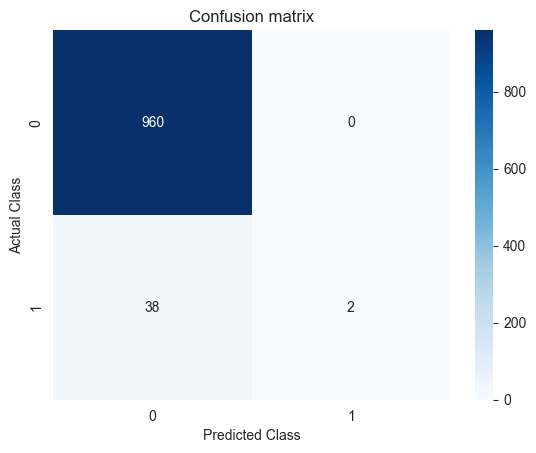

In [28]:
# Showing confusion matrix illustrating the above-mentioned problem with class imbalance.
example_confusion_matrix = np.array([[960,0],[38,2]])
fig = plot_confusion_matrix(example_confusion_matrix)
plt.show()

## Comparing different models

The above aproach of printing the model's performance for every n-th step is sufficient enough for a single model. But imagine you want to try running the model with different hyper-parameters. Then you'd need to save all the statistics somewhere, possibly with the train and validation accuracy plots, somewhere to your laptop and make sure you have the metrics properly labeled. That would require too much manual work. So instead, we can use the TensorBoard library that provides a convenient way to store different statistics for the models and let's you visualize the metrics across different models. To see how to do that, check the [tensorboard with pytorch documentation](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html).

In [29]:
# Train the model here
def train_model(iter, validation_every_steps):
    train_accuracies = []
    valid_accuracies = []
    
    step = 0
    model.train()
    for epoch in range(iter):
        train_accuracies_batches = []
        for inputs, targets in train_loader:
            output = model(inputs)
            loss = loss_fn(output, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            step += 1

            predictions = output.max(1)[1]
            train_accuracies_batches.append(accuracy_score(targets, predictions))
            
            if step % validation_every_steps == 0:
                train_accuracies.append(np.mean(train_accuracies_batches))
                train_accuracies_batches = []
                valid_accuracies_batches = []
                with torch.no_grad():
                    model.eval()
                    for inputs, targets in valid_loader:
                        output = model(inputs)
                        loss = loss_fn(output, targets)
                        predictions = output.max(1)[1]
                        valid_accuracies_batches.append(accuracy_score(targets, predictions) * len(inputs))
    
                    model.train()

                valid_accuracies.append(np.sum(valid_accuracies_batches) / len(valid_set))
                
                writer.add_scalar("Loss/train", train_accuracies[-1], epoch)
                writer.add_scalar("Loss/validation", valid_accuracies[-1], epoch)

### Linear model

In [30]:
class LinearModel(nn.Module):

    def __init__(self, num_features, num_classes):
        super(LinearModel, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(num_features, num_classes)
        )
        
    def forward(self, x):
        return self.net(x)

# Get sizes of input and output vectors. We'll use them to set proper dimensions for the model.
num_features = train_set.X.shape[1]
num_classes = train_set.y.unique().shape[0]

# Initialize the model.
model = LinearModel(num_features, num_classes)
print(model)

# Initialize the loss function and optimizer. Possibly also weights to deal with class imbalance.
weights = get_weights(train_set.y.numpy())
loss_fn = nn.CrossEntropyLoss(weight=weights)  # Setting the weights ensures the loss will be computed with respect to the imbalance in the dataset.
# loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

LinearModel(
  (net): Sequential(
    (0): Linear(in_features=15, out_features=2, bias=True)
  )
)


In [31]:
from torch.utils.tensorboard import SummaryWriter

# The writer will output to ./runs/ directory. Change the subdirectory to keep the experiment organized.
writer = SummaryWriter('runs/linear_model_1_layer')

train_model(iter=10, validation_every_steps=1000)

writer.flush()  # Makes sure that all pending events have been written to disk.
writer.close()

### Nonlinear model

In [32]:
class NonlinearModel(nn.Module):

    def __init__(self, num_features, num_classes):
        super(NonlinearModel, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(num_features, 20),
            nn.ReLU(),
            nn.Linear(20, num_classes)
        )
        
    def forward(self, x):
        return self.net(x)

# Get sizes of input and output vectors. We'll use them to set proper dimensions for the model.
num_features = train_set.X.shape[1]
num_classes = train_set.y.unique().shape[0]

# Initialize the model.
model = NonlinearModel(num_features, num_classes)
print(model)

# Initialize the loss function and optimizer. Possibly also weights to deal with class imbalance.
weights = get_weights(train_set.y.numpy())
# loss_fn = nn.CrossEntropyLoss(weight=weights)  # Setting the weights ensures the loss will be computed with respect to the imbalance in the dataset.
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# The writer will output to ./runs/ directory. Change the subdirectory to keep the experiment organized.
writer = SummaryWriter('runs/nonlinear_model_2_layers')
train_model(iter=10, validation_every_steps=1000)
writer.flush()  # Makes sure that all pending events have been written to disk.
writer.close()

NonlinearModel(
  (net): Sequential(
    (0): Linear(in_features=15, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=2, bias=True)
  )
)


### Visualization of the models' performance

To visualize the results, you can run the following command in the terminal:
```
tensorboard --logdir=runs
```
Then, open the browser and go to the following address:
```
http://localhost:6006/
```
The result should look like this:

![title](./tensorboard-screen-capture.png)

**Assignment**
* Play with the model. Change the number of layers or type of the layers; change the path in the SummaryWriter; train the model and compare the results with the model we've trained during the lecture. Use TensorBoard for the comparison.